In [92]:
import json
import os

import numpy as np
import pandas as pd
import plotly.express as px
import requests

from itertools import pairwise

In [2]:
os.chdir("..")

# fetch data

In [3]:
api_key = os.environ.get("MARKETSTACK_API_KEY")

In [4]:
dates = ["2020-01-01", "2021-01-01", "2022-01-01", "2023-01-01", "2024-11-10"]

In [50]:
ticker = "PLTR"

In [51]:
url = f"https://api.marketstack.com/v1/eod?access_key={api_key}"

In [52]:
file_path = f"data/daily/{ticker}.json"

In [53]:
data = []

if os.path.exists(file_path):
    print("File exists!")
else:
    for date_from, date_to in pairwise(dates):
        params = {
            "symbols": ticker,
            "date_from": date_from,
            "date_to": date_to,
            "sort": "ASC",
            "limit": 1000
        }
        response = requests.get(url, params=params)
        if response.ok:
            data += response.json()["data"]

    with open(file_path, "w") as file:
        json.dump(data, file, indent=4)

In [54]:
with open(file_path, "r") as file:
    data = json.load(file)

# load data

In [55]:
df = pd.DataFrame(data)

In [56]:
df["date"] = pd.to_datetime(df["date"])
df["week"] = df["date"] - pd.offsets.Week(weekday=6)

In [57]:
df[df["date"].between("2022-08-10", "2022-08-31")][["symbol", "date", "close", "adj_close", "split_factor"]]

,symbol,date,close,adj_close,split_factor
371,PLTR,2022-08-10 00:00:00+00:00,9.59,9.59,1.0
372,PLTR,2022-08-11 00:00:00+00:00,9.42,9.42,1.0
373,PLTR,2022-08-12 00:00:00+00:00,9.91,9.91,1.0
374,PLTR,2022-08-15 00:00:00+00:00,9.91,9.91,1.0
375,PLTR,2022-08-16 00:00:00+00:00,9.74,9.74,1.0
376,PLTR,2022-08-17 00:00:00+00:00,9.43,9.43,1.0
377,PLTR,2022-08-18 00:00:00+00:00,9.15,9.15,1.0
378,PLTR,2022-08-19 00:00:00+00:00,8.51,8.51,1.0
379,PLTR,2022-08-22 00:00:00+00:00,8.07,8.07,1.0
380,PLTR,2022-08-23 00:00:00+00:00,8.01,8.01,1.0


In [58]:
df[df["split_factor"]!=1]

,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,date,week


In [59]:
def calculate_split_factor(x):
    split_factor = [1] + df["split_factor"].to_list()[::-1][:-1]
    current = 1
    new_split_factor = []
    for previous in split_factor:
        new_factor = previous * current
        new_split_factor.append(new_factor)
        current = new_factor
    return new_split_factor[::-1]

In [60]:
df["net_split_factor"] = calculate_split_factor(df["split_factor"])
df["real_adj_close"] = (df["close"] / df["net_split_factor"]).round(4)

# some plots

<Axes: xlabel='date'>

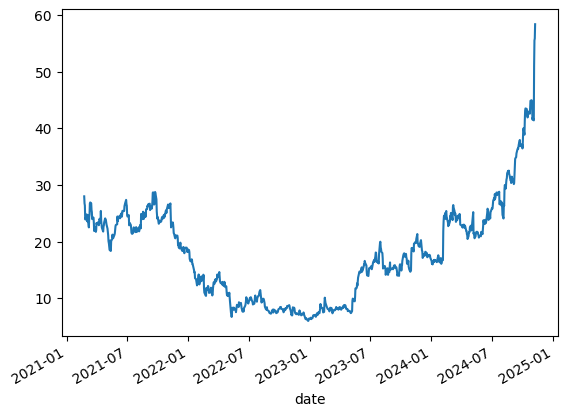

In [61]:
df.set_index("date")["close"].plot.line()

<Axes: xlabel='date'>

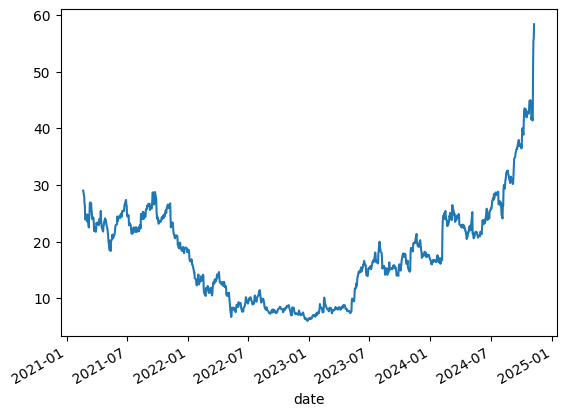

In [62]:
df.set_index("date")["adj_close"].plot.line()

<Axes: xlabel='date'>

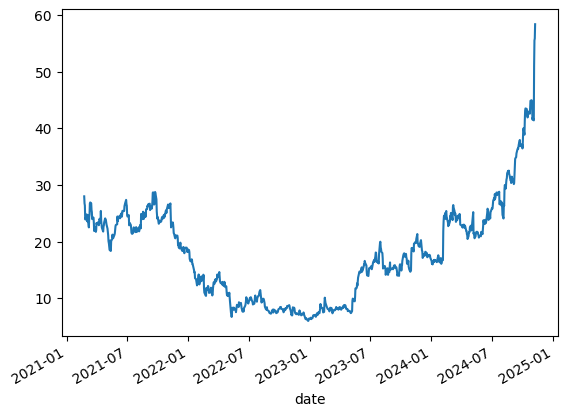

In [63]:
df.set_index("date")["real_adj_close"].plot.line()

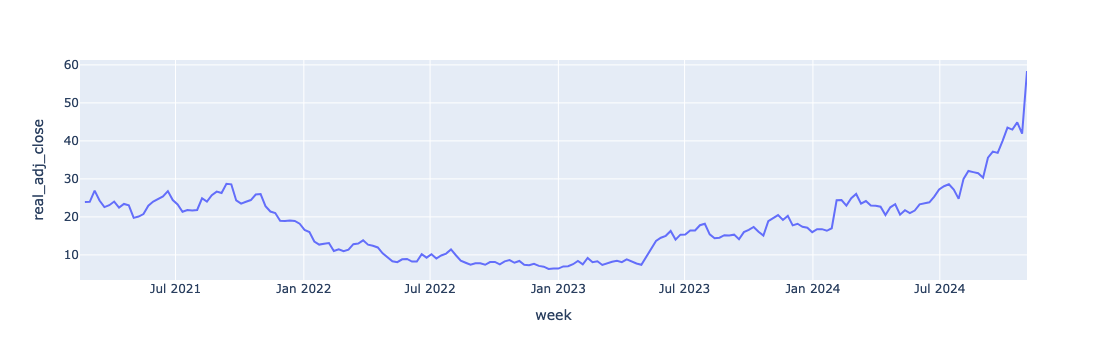

In [64]:
fig = px.line(data_frame=df.groupby("week")["real_adj_close"].last().reset_index(), x="week", y="real_adj_close")
fig.update_layout(hovermode="x")
fig.show()

In [65]:
df[df["date"].between("2021-10-25", "2021-11-05")][["date", "week", "real_adj_close"]]

,date,week,real_adj_close
172,2021-10-25 00:00:00+00:00,2021-10-24 00:00:00+00:00,25.41
173,2021-10-26 00:00:00+00:00,2021-10-24 00:00:00+00:00,25.52
174,2021-10-27 00:00:00+00:00,2021-10-24 00:00:00+00:00,25.06
175,2021-10-28 00:00:00+00:00,2021-10-24 00:00:00+00:00,25.64
176,2021-10-29 00:00:00+00:00,2021-10-24 00:00:00+00:00,25.88
177,2021-11-01 00:00:00+00:00,2021-10-31 00:00:00+00:00,26.56
178,2021-11-02 00:00:00+00:00,2021-10-31 00:00:00+00:00,25.92
179,2021-11-03 00:00:00+00:00,2021-10-31 00:00:00+00:00,26.12
180,2021-11-04 00:00:00+00:00,2021-10-31 00:00:00+00:00,26.47
181,2021-11-05 00:00:00+00:00,2021-10-31 00:00:00+00:00,26.00


# strategies

A strategy is a set of buy/sell timestamps. 

In [79]:
strategies = {}

In [93]:
df["weekly_rank"] = df.groupby("week")["real_adj_close"].rank()
df["monthly_rank"] = df.groupby(pd.Grouper(key="date", freq="MS"))["real_adj_close"].rank()
df["monthly_rank_desc"] = df.groupby(pd.Grouper(key="date", freq="MS"))["real_adj_close"].rank(ascending=False)
df["random_day_in_month"] = df.groupby(pd.Grouper(key="date", freq="MS"))["date"].apply(np.random.choice)

In [94]:
df[["symbol", "date", "real_adj_close", "monthly_rank", "monthly_rank_desc", "random_day_in_month"]]

,symbol,date,real_adj_close,monthly_rank,monthly_rank_desc,random_day_in_month
0,PLTR,2021-02-19 00:00:00+00:00,NaN,NaN,NaN,NaT
1,PLTR,2021-02-22 00:00:00+00:00,28.00,5.0,1.0,NaT
2,PLTR,2021-02-23 00:00:00+00:00,26.75,4.0,2.0,NaT
3,PLTR,2021-02-24 00:00:00+00:00,26.39,3.0,3.0,NaT
4,PLTR,2021-02-25 00:00:00+00:00,23.96,2.0,4.0,NaT
...,...,...,...,...,...,...
933,PLTR,2024-11-04 00:00:00+00:00,41.41,1.0,6.0,NaT
934,PLTR,2024-11-05 00:00:00+00:00,51.13,3.0,4.0,NaT
935,PLTR,2024-11-06 00:00:00+00:00,55.53,4.0,3.0,NaT
936,PLTR,2024-11-07 00:00:00+00:00,55.88,5.0,2.0,NaT


## strategy 1: buy on the lowest day of every week

In [127]:
strategies["oracle"] = {"buy": df.loc[df["monthly_rank"]==1, "date"].to_list()}
strategies["oracle"]["sell"] = []

## strategy 2: buy on the highest day of every week

In [128]:
strategies["bad_luck"] = {"buy": df.loc[df["monthly_rank_desc"]==1, "date"].to_list()}
strategies["bad_luck"]["sell"] = []

## strategy 3: random day in month

In [129]:
strategies["let_it_be"] =  {"buy": df.groupby(pd.Grouper(key="date", freq="MS")).agg(random_date=("date", np.random.choice))["random_date"].to_list()}
strategies["let_it_be"]["sell"] = []

## plot :)

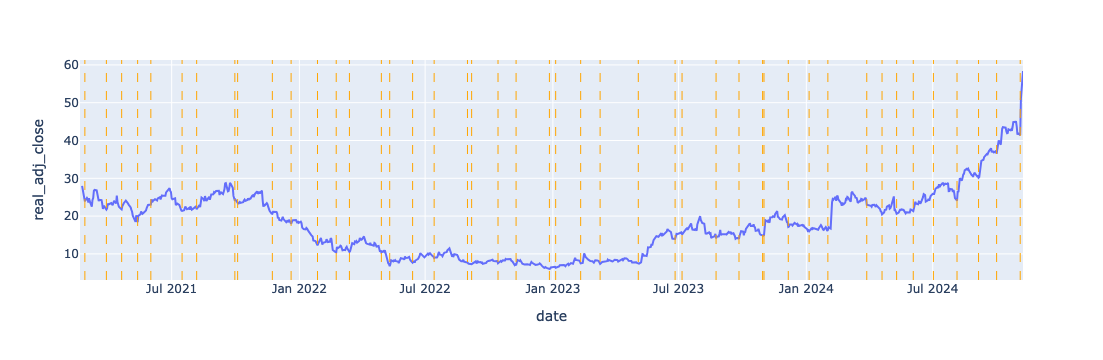

In [130]:
fig = px.line(data_frame=df, x="date", y="real_adj_close")
for buy_date in strategies["oracle"]["buy"]:
    fig.add_vline(x=buy_date, line_width=1, line_dash="dash", line_color="orange")
fig.update_layout(hovermode="x")
fig.show()